In [8]:
#Import libraries

import numpy as np
from numpy import argmax
import os
import matplotlib.pyplot as plt
import pickle
import math

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [9]:
#Define Data gemerator

rng = np.random.default_rng()
class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\test_dir"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        return np.array([np.load(file_name) for file_name in paths])

In [10]:
#All paths

Path = "/home/ug-ml/felix-ML/DataGenerator2/Data" #Path where training and validation data is
SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
SaveFolderName = "/Convnet2" #Will create a folder and put in information about the outcome / inputs
ModelName = "/Convnet2.hdf5"

batch_size = 32

In [11]:
#Load data generators

data = [i for i in gen_paths_labels(Path)]
#data[0][0] is training paths data[0][1] is training labels
#data[1][0] is val paths data[1][1] is val labels
print("data done.")
training_seq = FelixSequence(data[0][0], data[0][1], batch_size, "npy")
print("training_seq done.")
#print(data[1][0])
val_images = arrs_from_paths(data[1][0], "npy")
print("val_images done.")
val_lab = to_categorical(data[1][1])
print("val_lab done.")
print("Complete")

data done.
training_seq done.
val_images done.
val_lab done.
Complete


In [12]:
model = load_model(SaveDataPath + SaveFolderName + ModelName)
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_18 (Separab (None, 128, 126, 126)     5060      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 63, 63)       0         
_________________________________________________________________
separable_conv2d_19 (Separab (None, 128, 61, 61)       17664     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 30, 30)       0         
_________________________________________________________________
separable_conv2d_20 (Separab (None, 128, 28, 28)       17664     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 14, 14)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)            

In [13]:
#Open Cif file containing crystal number and lattice parameter
PathCif = "/home/ug-ml/felix-ML/DataGenerator2/CifFolder/CifKey_.txt"
with open(PathCif) as textFile:
        lines = [line.split() for line in textFile]

#Read the array taken from the file and cast strings to int and floats        
CifInfo = []
for i in lines:
    CrystalNo = int(i[0])
    lattice = float(i[1])
    CifInfo.append([CrystalNo, lattice])

    

ValidationPath = data[1][0] #The paths to all the validation crystals
ValCrystalsThickness = [] #Put crystal number and thickness to this array
for i in ValidationPath:
    CrystalNo = int(i.split("/")[-1].split("_")[-1].split(".")[0]) #Crystal number
    Thickness = int(i.split("/")[-2]) #Crystal classification thickness
    ValCrystalsThickness.append([CrystalNo, Thickness])

#Append lattice parameter to the array containg crystal number and thickness
for i in CifInfo:
    for j in ValCrystalsThickness:
        if(i[0] == j[0]):
            j.append(i[1]) #Now in the form [Crystal Number, Thickness, lattice parameter]


 
#Store predicted values of crystal thickness classification. The array elements will match with ValidationPath.
Predicted = model.predict_classes(val_images)

#Make a new 2D array to put elements [CorrectLabel, Predicted - CorrectLabel, Lattice Parameter]
TotalDifference = []
for i in range(0, len(Predicted)):
    Difference = Predicted[i] - ValCrystalsThickness[i][1] 
    TotalDifference.append([ValCrystalsThickness[i][1], Difference, ValCrystalsThickness[i][2]])
#print(TotalDifference)


#To visualise data more clearly we will make a histogram
LatticeRange = 40 #The lattice parameter roughly ranges between 5-35, so pick interval 0 - 39
LatticeValues = np.arange(LatticeRange) #Make list of integers from 0 - 39
LatticeBins = np.zeros(LatticeRange * 4).reshape(LatticeRange, 4) #[Number in bin, average difference, ave RMS, accuracy]


for i in TotalDifference:
    lattice = math.floor(i[2]) #Look at lattice parameter and floor its values. Put data into the corresponding bin
    LatticeBins[lattice][0]+=1 #Add 1 to number in bin
    LatticeBins[lattice][1]+=i[1] #Add difference between predicted and correct classification e.g (7 - 4 = 3)
    LatticeBins[lattice][2]+=(i[1]) ** 2 #Add square of difference to bin
    if(i[1] == 0):
        LatticeBins[lattice][3]+=1 #If predicted - correct classification = 0 (i.e correctly identified) add 1
    
for i in LatticeBins:
    if(i[0] != 0): #Ignore bins with not values inside
        i[1] = i[1] / i[0] #divide by number in bin to get average
        i[2] = (i[2] / i[0]) ** 0.5 #mean and root values to get RMS
        i[3] = i[3] / i[0] #divide by numeber in bin to get accuracy

#print(LatticeBins)


<Figure size 432x288 with 0 Axes>

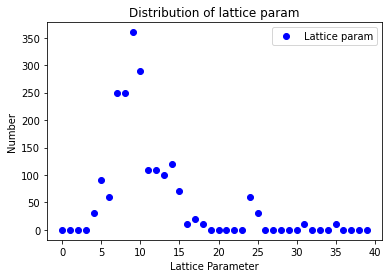

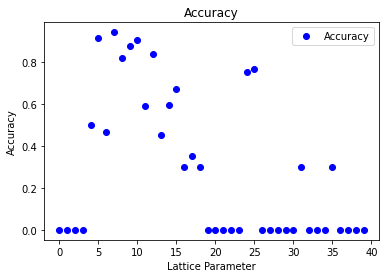

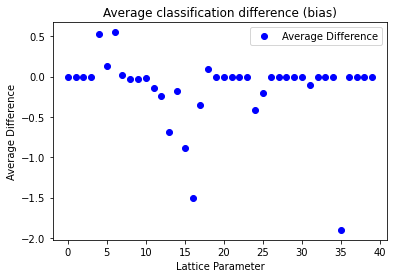

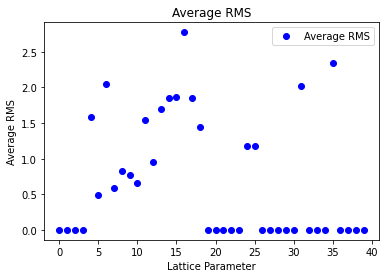

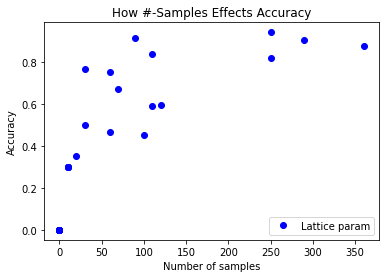

<Figure size 432x288 with 0 Axes>

In [14]:
#Plot 2 Distribution of lattice param

plt.plot(LatticeValues, LatticeBins[:,0], 'bo', label='Lattice param')
plt.title('Distribution of lattice param')
plt.xlabel('Lattice Parameter')
plt.ylabel('Number')
plt.legend()
plt.figure()

#Plot 3 Accuracy plot vs lattice parameter

plt.plot(LatticeValues, LatticeBins[:,3], 'bo', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Lattice Parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Plot 4 Average classification difference (bias)

plt.plot(LatticeValues, LatticeBins[:,1], 'bo', label='Average Difference')
plt.title('Average classification difference (bias)')
plt.xlabel('Lattice Parameter')
plt.ylabel('Average Difference')
plt.legend()
plt.figure()

#Plot 5 Average RMS

plt.plot(LatticeValues, LatticeBins[:,2], 'bo', label='Average RMS')
plt.title('Average RMS')
plt.xlabel('Lattice Parameter')
plt.ylabel('Average RMS')
plt.legend()
plt.figure()

#Plot 6 How #-Samples Effects Accuracy

plt.plot(LatticeBins[:,0], LatticeBins[:,3], 'bo', label='Lattice param')
plt.title('How #-Samples Effects Accuracy')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
